### Gradient Descent Optimizers Implementation with Tree Aggregate in PySpark
### Author: 
* Yi Rong (yirong@bu.edu)
* Xiaoyang Wang (gnayoaix@bu.edu)

### Date: 05/24/2021

In [141]:
from __future__ import print_function
import sys

from operator import add
# from string import lowercase
from re import sub, search
import numpy as np
from numpy.random.mtrand import dirichlet, multinomial
from string import punctuation
import random
import time
import math

from scipy.stats import norm
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from random import sample

from pyspark.sql import functions as f, udf
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.mllib.stat import Statistics
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

### Generate Data with make_blobs

In [144]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 400 # max iterations 
n=10000 # the number of total samples

In [145]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = [0.5] * n_components, # the std of each cluster
                  random_state=2) # 2

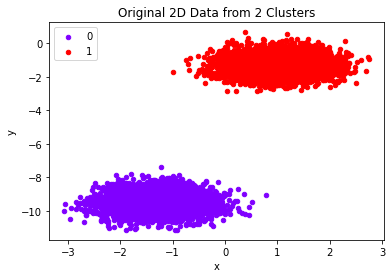

In [146]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

### Train a Logistic Regression Model

In [147]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.9, 0.1], seed=12345)
traindata.cache()

PythonRDD[86171] at RDD at PythonRDD.scala:53

In [148]:
train_size = traindata.count()

## Greadient Descent Optimizers

### Stochastic Gradient Descent (SGD)
### $\theta = \theta -  \eta \cdot \nabla_{\theta} J(θ) $

### Momentum

### $\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ)$

### $\theta = \theta - \nu_{t}$

### Nesterov accelerated gradient

### $\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ - \gamma \nu_{t-1})$

### $\theta = \theta - \nu_{t}$

or 

### $\theta_{temp} = \theta_{t} - \gamma \nu_{t-1}$

### $\theta_{t+1} = \theta_{temp} - \nabla_{\theta} J(θ)$

### $\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ)$

### Adagrad

### $\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{G_{t}+\epsilon}} \cdot g_{t}$

where $G_{t} \in \mathbb{R}^{d\times d}$ is a diagonal matrix where each diagonal element is the sum of the squares of the
gradients up to time step $t$.

### RMSprop

### $E[g^{2}]_{t} = \beta E[g^{2}]_{t-1} + (1-\beta )g^{2}_{t}$

### $\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{E[g^{2}]_{t} +\epsilon}} \cdot g_{t}$

where $E[g^{2}]$ is an exponentially decaying average of squared gradients.

### Adam

### $m_{t} = \beta_{1}m_{t-1}+(1-\beta_{1})g_{t}$

### $\nu_{t} = \beta_{2} \nu_{t-1} + (1-\beta_{2})g^{2}_{t}$

### $ \hat{m_{t}} =\frac{m_{t}}{1-\beta^{t}_{1}}$

### $ \hat{\nu_{t}} =\frac{\nu_{t}}{1-\beta^{t}_{2}}$

### $\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{\hat{\nu_{t}} +\epsilon}} \cdot \hat{m_{t}}$

### reference: https://arxiv.org/pdf/1609.04747.pdf

In [160]:
def LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta = 0.9,
                       beta2 = 0.999,
                       optimizer = 'SGD'  #optimizer: 'Momentum' / 'Adam' / 'Nesterov' / 'Adagrad' / 'RMSprop' / 'SGD' 
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    train_size = traindata.count()

    parameter_size = len(traindata.take(1)[0][1]) + 1
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)
#     parameter_vector = np.zeros(parameter_size) # initialize with zeros
    momentum = np.zeros(parameter_size)
    prev_mom = np.zeros(parameter_size)
    second_mom = np.array(parameter_size)
    gti = np.zeros(parameter_size)
    epsilon = 10e-8
    
    for i in range(max_iteration):

        bc_weights = parameter_vector[:-1]
        bc1_weights = parameter_vector[-1]

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (np.append(y[1], 1)) * (-y[0] + (np.exp(np.dot(y[1], bc_weights) + bc1_weights)\
                          /(1 + np.exp(np.dot(y[1], bc_weights) + bc1_weights)))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights) + bc1_weights)) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights)+ bc1_weights)),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))

        cost =  res[1] + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / res[2]) * res[0] + 2 * regularization * parameter_vector
        
        if optimizer == 'SGD':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='Momentum':
            momentum = beta * momentum + learningRate * gradient_derivative
            parameter_vector = parameter_vector - momentum
            
        if optimizer == 'Nesterov':
            parameter_temp = parameter_vector - beta * prev_mom
            parameter_vector = parameter_temp - learningRate * gradient_derivative
            prev_mom = momentum
            momentum = beta * momentum + learningRate * gradient_derivative
            
        if optimizer == 'Adam':
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            second_mom = beta2 * second_mom + (1 - beta2) * (gradient_derivative**2)
            momentum_ = momentum / (1 - beta**(i + 1))
            second_mom_ = second_mom / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum_ / (np.sqrt(second_mom_) + epsilon)

        if optimizer == 'Adagrad':
            gti += gradient_derivative**2
            adj_grad = gradient_derivative / (np.sqrt(gti)  + epsilon)
            parameter_vector = parameter_vector - learningRate  * adj_grad
        
        if optimizer == 'RMSprop':
            sq_grad = gradient_derivative**2
            exp_grad = beta * gti / (i + 1) + (1 - beta) * sq_grad
            parameter_vector = parameter_vector - learningRate / np.sqrt(exp_grad + epsilon) * gradient_derivative
            gti += sq_grad
            
        if i%20 == 0 :
            print("Iteration No.", i, " Cost=", cost)
            
#         print("Iteration No.", i, " Cost=", cost)
        
        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

### Model Training

#### SGD

In [161]:
parameter_vector_sgd, L_cost_sgd = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'SGD' 
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 195.8638143487128
Iteration No. 40  Cost= 178.67982067084822
Iteration No. 60  Cost= 173.58143637606548
Iteration No. 80  Cost= 157.97454898432036
Iteration No. 100  Cost= 156.75024256823139
Iteration No. 120  Cost= 150.60917837497507
Iteration No. 140  Cost= 134.6956510724494
Iteration No. 160  Cost= 137.38890085206134
Iteration No. 180  Cost= 136.40318149267034
Iteration No. 200  Cost= 107.45645844755487
Iteration No. 220  Cost= 112.73745727919051
Iteration No. 240  Cost= 113.28670797076897
Iteration No. 260  Cost= 97.70932210200313
Iteration No. 280  Cost= 98.84289038770584
Iteration No. 300  Cost= 96.66968666789494
Iteration No. 320  Cost= 98.74801640407506
Iteration No. 340  Cost= 99.9234880492304
Iteration No. 360  Cost= 87.5457426226855
Iteration No. 380  Cost= 85.18174256969155


#### Adam

In [162]:
parameter_vector_adam, L_cost_adam = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta2 = 0.999,
                       optimizer = 'Adam'
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 257.47602684020507
Iteration No. 40  Cost= 239.5417301779561
Iteration No. 60  Cost= 228.8011763429062
Iteration No. 80  Cost= 209.48628334506358
Iteration No. 100  Cost= 210.17592438589062
Iteration No. 120  Cost= 206.97353950309295
Iteration No. 140  Cost= 193.2703517536573
Iteration No. 160  Cost= 198.34769848533043
Iteration No. 180  Cost= 202.34546760384742
Iteration No. 200  Cost= 165.76469992808006
Iteration No. 220  Cost= 174.36964770830065
Iteration No. 240  Cost= 179.99370205382763
Iteration No. 260  Cost= 156.5183786667344
Iteration No. 280  Cost= 161.33464501376542
Iteration No. 300  Cost= 161.52836614015266
Iteration No. 320  Cost= 165.50173478859236
Iteration No. 340  Cost= 166.6825811864354
Iteration No. 360  Cost= 154.33889841676356
Iteration No. 380  Cost= 149.53554042127965


#### Momentum

In [163]:
parameter_vector_momentum, L_cost_momentum = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Momentum'
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 143.50598517069872
Iteration No. 40  Cost= 87.90170898309614
Iteration No. 60  Cost= 68.01621791723733
Iteration No. 80  Cost= 55.90425378271596
Iteration No. 100  Cost= 50.983588113300236
Iteration No. 120  Cost= 44.56344753637255
Iteration No. 140  Cost= 37.18474315437171
Iteration No. 160  Cost= 38.993173791422706
Iteration No. 180  Cost= 38.04090499385265
Iteration No. 200  Cost= 30.44503808634857
Iteration No. 220  Cost= 33.13654291444172
Iteration No. 240  Cost= 32.06972221949955
Iteration No. 260  Cost= 29.02954012271521
Iteration No. 280  Cost= 29.609602121988015
Iteration No. 300  Cost= 29.497462638369946
Iteration No. 320  Cost= 30.597393035938072
Iteration No. 340  Cost= 32.852791550204934
Iteration No. 360  Cost= 25.6256028155042
Iteration No. 380  Cost= 26.75930096129786


#### Nesterov

In [164]:
parameter_vector_nesterov, L_cost_nesterov = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Nesterov'
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 153.37934064278886
Iteration No. 40  Cost= 88.4147822804283
Iteration No. 60  Cost= 67.14940954707028
Iteration No. 80  Cost= 55.15764872201109
Iteration No. 100  Cost= 50.38567236024413
Iteration No. 120  Cost= 44.06267931616216
Iteration No. 140  Cost= 36.81496824890174
Iteration No. 160  Cost= 38.672933811962515
Iteration No. 180  Cost= 37.7643090061225
Iteration No. 200  Cost= 30.260939438882577
Iteration No. 220  Cost= 32.96537017536998
Iteration No. 240  Cost= 31.916020493217076
Iteration No. 260  Cost= 28.91523826555479
Iteration No. 280  Cost= 29.50407614334269
Iteration No. 300  Cost= 29.409628482210167
Iteration No. 320  Cost= 30.515378785161502
Iteration No. 340  Cost= 32.77756951894879
Iteration No. 360  Cost= 25.563907135522847
Iteration No. 380  Cost= 26.704533020455838


#### Adagrad

In [165]:
parameter_vector_adagrad, L_cost_adagrad = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Adagrad'
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 212.14122844499258
Iteration No. 40  Cost= 193.25879827222352
Iteration No. 60  Cost= 186.00405700443477
Iteration No. 80  Cost= 171.24028770060053
Iteration No. 100  Cost= 171.60001109762854
Iteration No. 120  Cost= 167.97162827093263
Iteration No. 140  Cost= 155.58665154845647
Iteration No. 160  Cost= 159.08157406597553
Iteration No. 180  Cost= 162.1601836128942
Iteration No. 200  Cost= 133.05620381467307
Iteration No. 220  Cost= 139.84692888087423
Iteration No. 240  Cost= 143.48833883201638
Iteration No. 260  Cost= 125.46331082928158
Iteration No. 280  Cost= 130.03571054033262
Iteration No. 300  Cost= 130.07473888667843
Iteration No. 320  Cost= 134.88746895434045
Iteration No. 340  Cost= 136.5373054087155
Iteration No. 360  Cost= 127.30623181510363
Iteration No. 380  Cost= 124.04007143528891


#### RMSprop

In [166]:
parameter_vector_rmsprop, L_cost_rmsprop = LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'RMSprop'
                      )

Iteration No. 0  Cost= 277.1715473129733
Iteration No. 20  Cost= 153.8687601168233
Iteration No. 40  Cost= 116.79396048423737
Iteration No. 60  Cost= 97.04270894252664
Iteration No. 80  Cost= 78.4630709743574
Iteration No. 100  Cost= 69.740741277584
Iteration No. 120  Cost= 60.37476102561391
Iteration No. 140  Cost= 49.130947963715506
Iteration No. 160  Cost= 48.455486175721134
Iteration No. 180  Cost= 45.742864013591905
Iteration No. 200  Cost= 35.148071390410415
Iteration No. 220  Cost= 36.667480791462616
Iteration No. 240  Cost= 35.18995696133875
Iteration No. 260  Cost= 30.596926904480185
Iteration No. 280  Cost= 30.987036161366273
Iteration No. 300  Cost= 30.34074827845004
Iteration No. 320  Cost= 30.97403938105697
Iteration No. 340  Cost= 32.68422907945869
Iteration No. 360  Cost= 26.362808461547274
Iteration No. 380  Cost= 26.921227466341428


### Optimizers Comparison

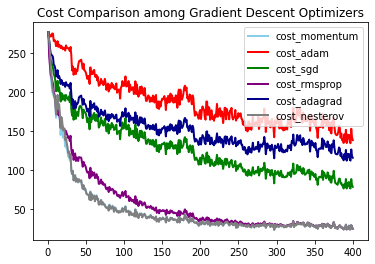

In [167]:
# Data
df = pd.DataFrame({'iteration': range(1, max_iter+1), 
                     'cost_momentum': L_cost_momentum, 
                     'cost_adam': L_cost_adam, 
                     'cost_sgd': L_cost_sgd,
                     'cost_rmsprop': L_cost_rmsprop,
                     'cost_adagrad': L_cost_adagrad,
                     'cost_nesterov': L_cost_nesterov})
 
# multiple line plots
pyplot.plot( 'iteration', 'cost_momentum', data=df, marker='', color='skyblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_adam', data=df, marker='', color='red', linewidth=2)
pyplot.plot( 'iteration', 'cost_sgd', data=df, marker='', color='green', linewidth=2)
pyplot.plot( 'iteration', 'cost_rmsprop', data=df, marker='', color='purple', linewidth=2)
pyplot.plot( 'iteration', 'cost_adagrad', data=df, marker='', color='darkblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_nesterov', data=df, marker='', color='grey', linewidth=2)
# show legend
pyplot.legend()
pyplot.title('Cost Comparison among Gradient Descent Optimizers')
# show graph
pyplot.show()